In [43]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
from scipy import signal
import configs
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.io import savemat
from matplotlib.pyplot import cm

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)
from datasets import inputs
import seaborn as sns
import pandas as pd

# Helper Functions

In [44]:
def get_scale_M(T, gamma, scale):
    return np.linalg.pinv(np.eye(T.shape[0])*scale - gamma*T)

In [45]:
def get_M(T, gamma):
    return np.linalg.pinv(np.eye(T.shape[0]) - gamma*T)
    
def normalize(T):
    row_sums = np.sum(T, axis=1)
    unvisited_states = (row_sums == 0)
    T = T/row_sums[:, np.newaxis]
    T[unvisited_states] = 0
    return T

# Running dataset

In [46]:
framerate = 10
num_steps = 10*60*3 + framerate + 1
num_states = 20

# Right-biased 1D Walk
dset = inputs.Sim1DWalk(
    num_steps=num_steps, left_right_stay_prob=[0.5, 1., 1],
    num_states=num_states
    )

# Set up dataset
dg_inputs = dset.dg_inputs.T
input_states = []
for t in range(dg_inputs.shape[0]):
    input_states.append(np.argwhere(dg_inputs[t])[0,0])
input_states = np.array(input_states)

counts = []
steps = []
count = np.zeros((num_states, num_states))
for step in range(1, dset.num_steps):
    count[input_states[step-1], input_states[step]] += 1
    if (step % framerate == 0) or (step < framerate//2):
        counts.append(count.copy())
        steps.append(step)

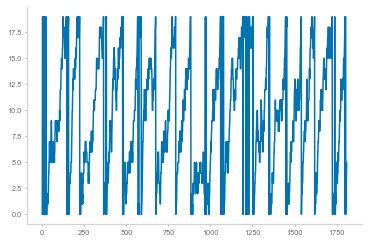

In [47]:
plt.figure()
plt.plot(input_states)
plt.show()

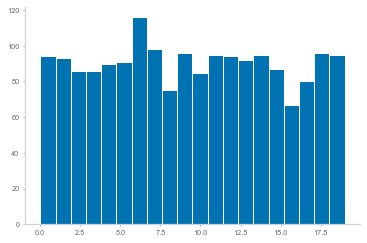

In [48]:
plt.figure()
plt.hist(input_states, bins=20)
plt.show()

# M from globally scaled counts

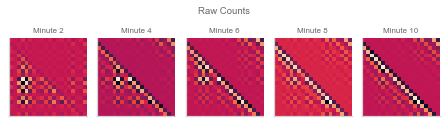

In [49]:
fig, axs = plt.subplots(1, 5, figsize=(6.25, 1.75))
fig.subplots_adjust(top=0.75)
count_idxs = np.array([2, 4, 6, 8, 10])
count_idxs = (count_idxs * 60*3)/framerate
count_idxs = count_idxs.astype(int) + (framerate//2-1)
for idx, count_idx in enumerate(count_idxs):
    count = counts[count_idx]
    T = count
    _min = int(((count_idx)*framerate)/3/60.)
    axs[idx].imshow(get_M(T, 0.9))
    axs[idx].set_title(f'Minute {_min}')
    axs[idx].set_xticks([]); axs[idx].set_yticks([])
plt.suptitle('Raw Counts')
plt.tight_layout()
plt.savefig('../figures/R1_rawcounts.png', dpi=300, transparent=True)
plt.show()

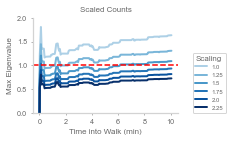

In [50]:
plt.figure(figsize=(2.6, 1.75))
scales = [1., 1.25, 1.5, 1.75, 2., 2.25]
colors = cm.get_cmap('Blues')(np.linspace(0.33, 1, len(scales)))
for scale_i, scale in enumerate(scales):
    eigs = []
    for count in counts:
        eigenval, _ = np.linalg.eig(count/(count.max()*scale))
        max_eigenval = np.max(np.real(eigenval))
        eigs.append(max_eigenval)
    plt.plot(
        np.array(steps)/60/3,
        eigs, label=scale, linewidth=2, color=colors[scale_i]
        )
plt.axhline(1.0, color='red', linestyle='--')
plt.ylabel('Max Eigenvalue')
plt.xlabel('Time into Walk (min)')
plt.xticks()
plt.yticks([0, 0.5, 1., 1.5, 2.])
plt.legend(
    title='Scaling',
    loc=(1.1, 0)
    )
plt.ylim(0)
plt.title('Scaled Counts',)
#plt.tight_layout()
plt.savefig(
    '../figures/R1_scale_eigs.png',
    dpi=300, transparent=True, bbox_inches='tight'
    )
plt.show()

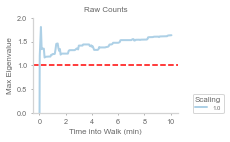

In [51]:
plt.figure(figsize=(2.6, 1.75))
scales = [1.]
for scale in scales:
    eigs = []
    for count in counts:
        eigenval, _ = np.linalg.eig(count/(count.max()*scale))
        max_eigenval = np.max(np.real(eigenval))
        eigs.append(max_eigenval)
    plt.plot(np.array(steps)/60/3, eigs, label=scale, linewidth=2, color=colors[0])
plt.axhline(1.0, color='red', linestyle='--')
plt.ylabel('Max Eigenvalue')
plt.xlabel('Time into Walk (min)')
plt.xticks()
plt.yticks([0, 0.5, 1., 1.5, 2.])
plt.ylim(0)
plt.title('Raw Counts')
plt.legend(
    title='Scaling',
    loc=(1.1, 0)
    )
plt.savefig(
    '../figures/R1_raw_eigs.png',
        dpi=300, transparent=True, bbox_inches='tight'
    )
plt.show()

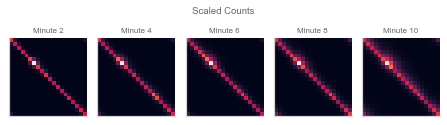

In [52]:
fig, axs = plt.subplots(1, 5, figsize=(6.25, 1.75))
fig.subplots_adjust(top=0.75)
count_idxs = np.array([2, 4, 6, 8, 10])
count_idxs = (count_idxs * 60*3)/framerate
count_idxs = count_idxs.astype(int)
for idx, count_idx in enumerate(count_idxs):
    count = counts[count_idx]
    T = count/(count.max()*1.75)
    _min = int(((count_idx)*framerate)/3/60.)
    axs[idx].imshow(get_M(T, 0.9))
    axs[idx].set_title(f'Minute {_min}')
    axs[idx].set_xticks([]); axs[idx].set_yticks([])
plt.suptitle('Scaled Counts')
plt.tight_layout()
plt.savefig('../figures/R1_scaled_raw.png', dpi=300, transparent=True)
plt.show()

# M from row scaled counts

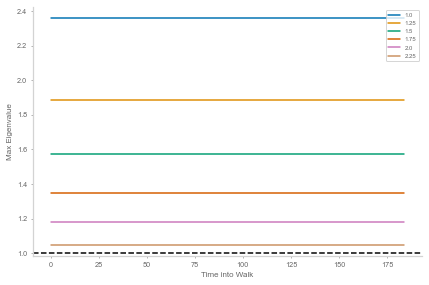

In [53]:
plt.figure()
scales = [1., 1.25, 1.5, 1.75, 2., 2.25]
for scale in scales:
    eigs = []
    for count in counts:
        count = counts[count_idx]
        count = count/(count.max(axis=1)[:, np.newaxis]*scale)
        count[np.isnan(count)] = 0
        eigenval, _ = np.linalg.eig(count)
        max_eigenval = np.max(np.real(eigenval))
        eigs.append(max_eigenval)
    plt.plot(eigs, label=scale)
plt.axhline(1.0, color='black', linestyle='--')
plt.ylabel('Max Eigenvalue')
plt.xlabel('Time into Walk')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/R1_rowscale_eigs.png', dpi=300, transparent=True)
plt.show()

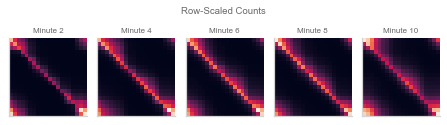

In [54]:
fig, axs = plt.subplots(1, 5, figsize=(6.25, 1.75))
fig.subplots_adjust(top=0.75)
count_idxs = np.array([2, 4, 6, 8, 10])
count_idxs = (count_idxs * 60*3)/framerate
count_idxs = count_idxs.astype(int)
for idx, count_idx in enumerate(count_idxs):
    count = counts[count_idx]
    count = count/(count.max(axis=1)[:, np.newaxis]*2.25)
    count[np.isnan(count)] = 0
    T = count
    _min = int(((count_idx)*framerate)/3/60.)
    axs[idx].imshow(get_M(T, 0.9))
    axs[idx].set_title(f'Minute {_min}')
    axs[idx].set_xticks([]); axs[idx].set_yticks([])
plt.suptitle('Row-Scaled Counts')
plt.tight_layout()
plt.savefig('../figures/R1_rowscale.png', dpi=300, transparent=True)
plt.show()

# M from correct T

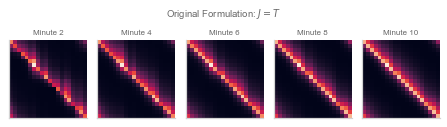

In [55]:
fig, axs = plt.subplots(1, 5, figsize=(6.25, 1.75))
fig.subplots_adjust(top=0.75)
count_idxs = np.array([2, 4, 6, 8, 10])
count_idxs = (count_idxs * 60*3)/framerate
count_idxs = count_idxs.astype(int)
for idx, count_idx in enumerate(count_idxs):
    count = counts[count_idx]
    T = normalize(count)
    _min = int(((count_idx)*framerate)/3/60.)
    axs[idx].imshow(get_M(T, 0.9))
    axs[idx].set_title(f'Minute {_min}')
    axs[idx].set_xticks([]); axs[idx].set_yticks([])
plt.suptitle('Original Formulation: $J=T$')
plt.tight_layout()
plt.savefig('../figures/R1_original.png', dpi=300, transparent=True)
plt.show()

# M from tanh counts

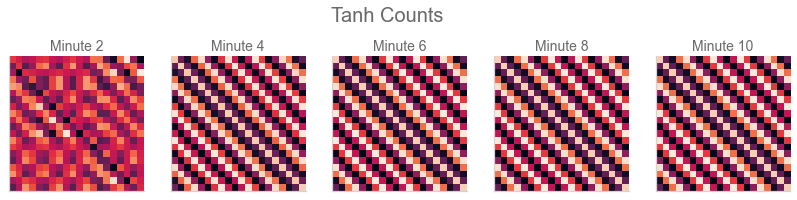

In [14]:
fig, axs = plt.subplots(1, 5, figsize=(14, 3))
fig.subplots_adjust(top=0.75)
count_idxs = np.array([2, 4, 6, 8, 10])
count_idxs = (count_idxs * 60*3)/framerate
count_idxs = count_idxs.astype(int)
for idx, count_idx in enumerate(count_idxs):
    count = counts[count_idx]
    count = np.tanh(count)
    T = count
    _min = int(((count_idx)*framerate)/3/60.)
    axs[idx].imshow(get_M(T, 0.9))
    axs[idx].set_title(f'Minute {_min}', fontsize=14)
    axs[idx].set_xticks([]); axs[idx].set_yticks([])
plt.suptitle('Tanh Counts', fontsize=20)
plt.show()